## Introduction

## Retrieval Augmented Generation (RAG)

RAG or semantic search with LLMs on data not included in base model has been an exciting development in AI. In this notebook, we will cover:
1. Fundamentals of RAG
2. RAG architecture
3. Hands-on implementation

RAG applications are a type of large language model that augment text generation with information retrieval.
* They retrieve relevant information from an external knowledge base to enhance their responses.
* This allows RAG apps to produce more informative responses across a wider range of prompts/questions.
* The RAG structure couples a text generator with a retriever module that queries the knowledge base.
  - This allows the model to incorporate up-to-date, real-world information into its text generation.
* The LLM retrieves pertinent data, then constructs coherent responses utilizing both its internal capabilities and the external knowledge.

Using a vector database, we will use one of the more powerful smaller (7b) parameter model to built a RAG system. Let's get started!

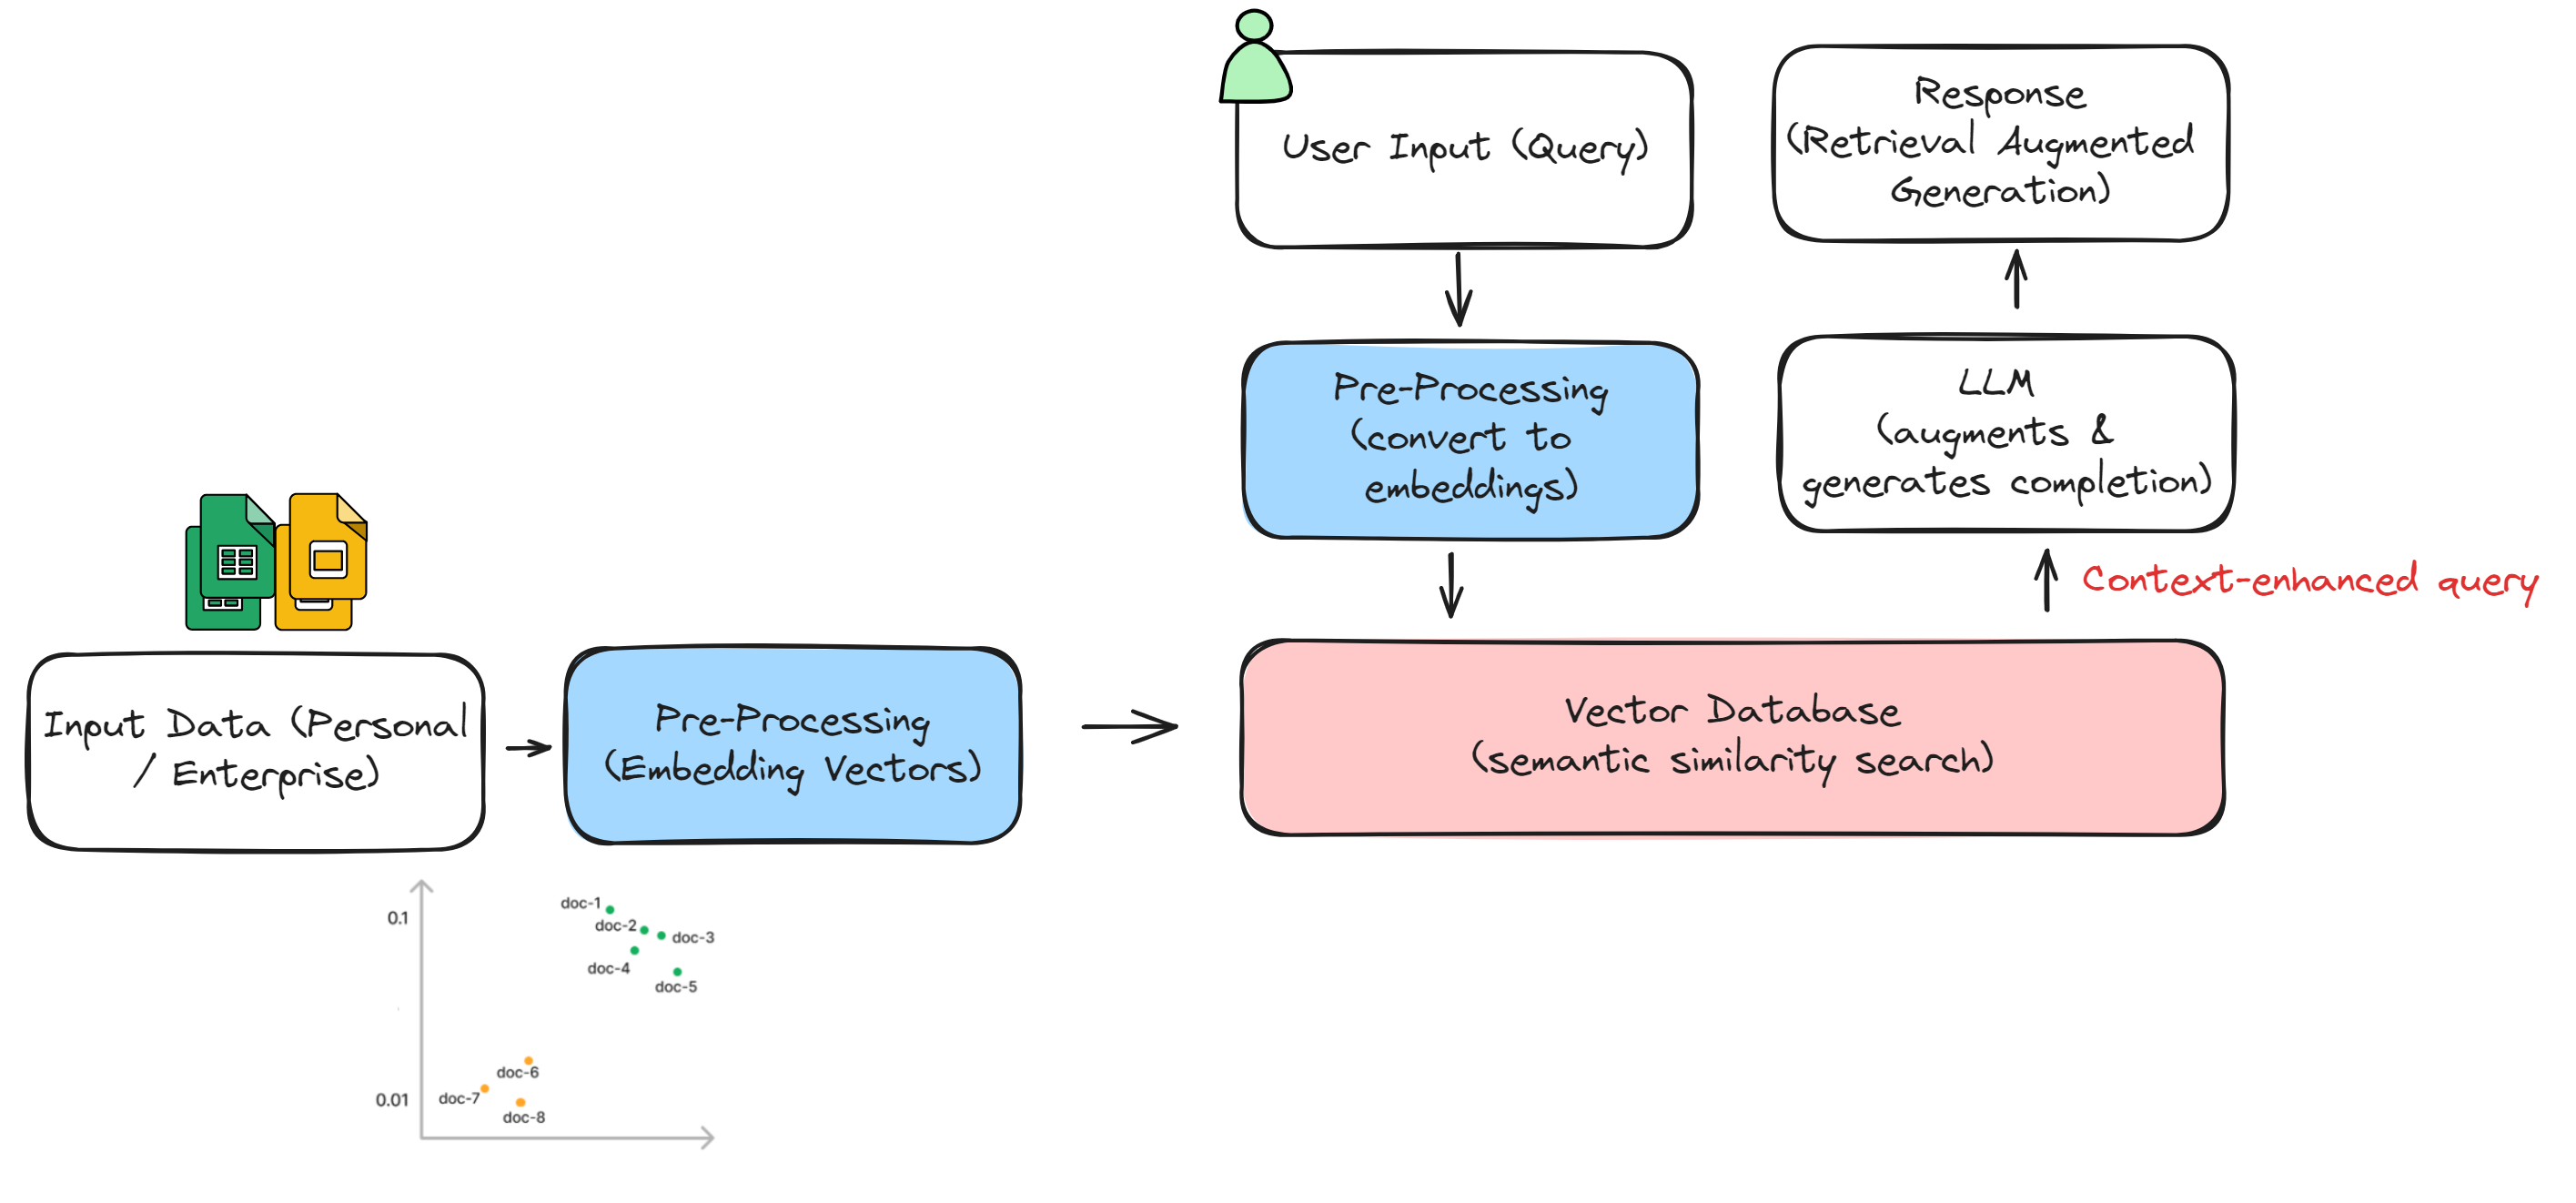

## Key libraries

We will work with `llama_index` and `langchain` libraries to perform document indexing and retrieval using GPT-3.5-turbo from OpenAI. This is a relatively advanced base LLM (closed-source) that doesn't break the bank with API queries. Our approach:
1. Set up the environment
2. Load documents
3. Create an index for efficient document retrieval

Requirement:
1. OpenAI API key (you can set one up now)

Steps:

1. Import the libraries we need - `llama_index` and `langchain`. 
2. Sample text data is loaded that can be used for training the LLM.
3. The LLMPredictor is initialized, specifying the LLM model (e.g. GPT-3.5-turbo) and temperature.
4. A ServiceContext object is created to enable efficient knowledge retrieval from the LLM.
5. The loaded documents are indexed using the ServiceContext to allow querying the LLM for answers about the custom dataset.
6. Overall, the code sets up authentication, loads data, initializes the model, and indexes documents to enable accessing and training a large language model.

## Dataset

- On the right of the panel, clik Add Data and enter this in the search bar: "topic-labeled-news-dataset"
- Click the "+" icon and then the 'X' at top right to exit out

In [4]:
%%capture pipout
!pip install langchain openai tiktoken duckduckgo-search youtube_search faiss-cpu==1.7.4 chromadb==0.3.21

In [9]:
!pip install faiss-cpu==1.7.4 chromadb==0.3.21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 67.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for clickhouse-connect>=0.5.7 from https://files.pythonhosted.org/packages/b9/a8/db0f1e3bdb3b35ccdaa605f3e6f9327006412872671250574245d7243268/clickhouse_connect-0.6.20-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for duckdb>=0.7.1 from https://files.pythonhosted.org/packages/d3/52/e20f7988add9f9584a9a6917d48dbcb0dae81d5e04132a94da486de69805/duckdb-0.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for posthog>=2.4.0 fr

In [7]:
mkdir cache

In [10]:
import chromadb
from chromadb.config import Settings

chroma_client = chromadb.Client(
    Settings(
        chroma_db_impl="duckdb+parquet",
        persist_directory="../working/cache/",  # this is an optional argument. If you don't supply this, the data will be ephemeral
    )
)

In [11]:
import pandas as pd

pdf = pd.read_csv("../input/topic-labeled-news-dataset/labelled_newscatcher_dataset.csv", sep=";")
pdf["id"] = pdf.index
display(pdf)

,topic,link,domain,published_date,title,lang,id
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en,0
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en,1
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en,2
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study,en,3
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...,en,4
...,...,...,...,...,...,...,...
108769,NATION,https://www.vanguardngr.com/2020/08/pdp-govern...,vanguardngr.com,2020-08-08 02:40:00,PDP governors’ forum urges security agencies t...,en,108769
108770,BUSINESS,https://www.patentlyapple.com/patently-apple/2...,patentlyapple.com,2020-08-08 01:27:12,"In Q2-20, Apple Dominated the Premium Smartpho...",en,108770
108771,HEALTH,https://www.belfastlive.co.uk/news/health/coro...,belfastlive.co.uk,2020-08-12 17:01:00,Coronavirus Northern Ireland: Full breakdown s...,en,108771
108772,ENTERTAINMENT,https://www.thenews.com.pk/latest/696364-paul-...,thenews.com.pk,2020-08-05 04:59:00,Paul McCartney details post-Beatles distress a...,en,108772


We will next encode the `title` column

## FAISS: Vector library

- Uses `SentenceTransformer` (HuggingFace model [repo](https://huggingface.co/sentence-transformers))for encoding the input text into vector
- The vectors are stored in the FAISS vector database
- Search (ex. L2 similarity, cosine similarity) against User query

References:
- Documentation: https://faiss.ai/
- Guide: https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index

## A quick aside on semantic search

- `Sentence Transformer` [repo](https://huggingface.co/sentence-transformers) has a list of models
- Detailed [documentation](https://www.sbert.net/) and usage

In [12]:
from sentence_transformers import InputExample

pdf_subset = pdf.head(1000)

def example_create_fn(doc1: pd.Series) -> InputExample:
    """
    Helper function that outputs a sentence_transformer guid, label, and text
    """
    return InputExample(texts=[doc1])

faiss_train_examples = pdf_subset.apply(
    lambda x: example_create_fn(x["title"]), axis=1
).tolist()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(
    "all-MiniLM-L6-v2", 
    cache_folder="../working/cache/"
)  # Use a pre-cached model
faiss_title_embedding = model.encode(pdf_subset.title.values.tolist())
len(faiss_title_embedding), len(faiss_title_embedding[0])

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

(1000, 384)

## Vector Dimension

Note, the vector dimension is 384: Each sentence (`title`) is converted into a vector of this length. 

## Saving embeddings to the FAISS index

- A short tutorial by HuggingFace on using this library [here](https://huggingface.co/learn/nlp-course/chapter5/6?fw=pt)

In [25]:
import numpy as np
import faiss

pdf_to_index = pdf_subset.set_index(["id"], drop=False)
id_index = np.array(pdf_to_index.id.values).flatten().astype("int")

content_encoded_normalized = faiss_title_embedding.copy()
faiss.normalize_L2(content_encoded_normalized)

# Index1DMap translates search results to IDs: https://faiss.ai/cpp_api/file/IndexIDMap_8h.html#_CPPv4I0EN5faiss18IndexIDMapTemplateE
# The IndexFlatIP below builds index
index_content = faiss.IndexIDMap(faiss.IndexFlatIP(len(faiss_title_embedding[0])))
index_content.add_with_ids(content_encoded_normalized, id_index)

## Search for relevant documents

- `top_k`
- `top_p`

In [26]:
def search_content(query, pdf_to_index, k=3):
    query_vector = model.encode([query])
    faiss.normalize_L2(query_vector)

    # We set k to limit the number of vectors we want to return
    top_k = index_content.search(query_vector, k)
    ids = top_k[1][0].tolist()
    similarities = top_k[0][0].tolist()
    results = pdf_to_index.loc[ids]
    results["similarities"] = similarities
    return results

In [33]:
display(search_content("holidays", pdf_to_index)) # try other terms

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,topic,link,domain,published_date,title,lang,id,similarities
id,,,,,,,,
703,TECHNOLOGY,https://www.yahoo.com/lifestyle/heres-everythi...,yahoo.com,2020-08-09 14:00:00,Here's Everything You Need to Host a Halloween...,en,703,0.334936
59,TECHNOLOGY,https://press-start.com.au/news/playstation/20...,press-start.com.au,2020-08-13 12:25:10,Fall Guys Is Giving Free Gifts To Anyone Who H...,en,59,0.298531
820,TECHNOLOGY,https://www.gamespot.com/articles/every-august...,gamespot.com,2020-08-05 06:08:00,"Every August 2020 Game Release For Switch, PS4...",en,820,0.288366


## The last step: LLM retrieval

- Using Chroma as a Vector Database

In [34]:
import chromadb
from chromadb.config import Settings

chroma_client = chromadb.Client(
    Settings(
        chroma_db_impl="duckdb+parquet",
        persist_directory="../working/cache/",  # this is an optional argument. If you don't supply this, the data will be ephemeral
    )
)

### Create a Chroma Collection

- Documentation [ref](https://docs.trychroma.com/usage-guide#using-collections)

In [35]:
collection_name = "my_news"

# If you have created the collection before, you need delete the collection first
if len(chroma_client.list_collections()) > 0 and collection_name in [
    chroma_client.list_collections()[0].name
]:
    chroma_client.delete_collection(name=collection_name)
else:
    print(f"Creating collection: '{collection_name}'")
    collection = chroma_client.create_collection(name=collection_name)

Creating collection: 'my_news'


## Add data to the collection

In [36]:
collection.add(
    documents=pdf_subset["title"][:100].tolist(),
    metadatas=[{"topic": topic} for topic in pdf_subset["topic"][:100].tolist()],
    ids=[f"id{x}" for x in range(100)],
)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

# Querying the Collection

In [37]:
import json
results = collection.query(query_texts=["space"], n_results=10)
print(json.dumps(results, indent=4))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{
    "ids": [
        [
            "id72",
            "id7",
            "id30",
            "id26",
            "id23",
            "id76",
            "id69",
            "id40",
            "id47",
            "id75"
        ]
    ],
    "embeddings": null,
    "documents": [
        [
            "Beck teams up with NASA and AI for 'Hyperspace' visual album experience",
            "Orbital space tourism set for rebirth in 2021",
            "NASA drops \"insensitive\" nicknames for cosmic objects",
            "\u2018It came alive:\u2019 NASA astronauts describe experiencing splashdown in SpaceX Dragon",
            "Hubble Uses Moon As \u201cMirror\u201d to Study Earth\u2019s Atmosphere \u2013 Proxy in Search of Potentially Habitable Planets Around Other Stars",
            "Australia's small yet crucial part in the mission to find life on Mars",
            "NASA Astronauts in SpaceX Capsule Splashdown in Gulf Of Mexico",
            "SpaceX's Starship spacecraft saw 150 mete

## Filters

- Metadata can be used for filtering queries

In [40]:
collection.query(query_texts=["space"], where={"topic": "SCIENCE"}, n_results=10)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'ids': [['id7',
   'id30',
   'id26',
   'id23',
   'id76',
   'id69',
   'id40',
   'id47',
   'id75',
   'id52']],
 'embeddings': None,
 'documents': [['Orbital space tourism set for rebirth in 2021',
   'NASA drops "insensitive" nicknames for cosmic objects',
   '‘It came alive:’ NASA astronauts describe experiencing splashdown in SpaceX Dragon',
   'Hubble Uses Moon As “Mirror” to Study Earth’s Atmosphere – Proxy in Search of Potentially Habitable Planets Around Other Stars',
   "Australia's small yet crucial part in the mission to find life on Mars",
   'NASA Astronauts in SpaceX Capsule Splashdown in Gulf Of Mexico',
   "SpaceX's Starship spacecraft saw 150 meters high",
   'NASA’s InSight lander shows what’s beneath Mars’ surface',
   'Alien base on Mercury: ET hunters claim to find huge UFO',
   'SpaceX Crew-1 mission with NASA, first fully operational crewed mission to space to launch in October']],
 'metadatas': [[{'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'},
   {'topic': '

## Updating the Collection

```
collection.delete(ids=["id0"])
collection.get(ids=["id0"],)

# Update
collection.get(ids=["id2"],)
collection.update(ids=["id2"], metadatas=[{"topic": "TECHNOLOGY"}],)
collection.get(ids=["id2"],)
```

In [36]:
import os
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import Ollama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.embeddings.ollama import OllamaEmbeddings
from langchain.embeddings.bedrock import BedrockEmbeddings
from langchain.prompts import PromptTemplate
from langchain.document_loaders import UnstructuredPDFLoader, OnlinePDFLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import DirectoryLoader
from langchain.chains import RetrievalQA


### [OPTIONAL] Set your OpenAI API key if you want to use their embedding model

If you are on Kaggle, go to "Add-Ons" in the Toolbar and add your OPENAI_API_KEY
Copy the code sample and modify it below if needed

In [37]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["OPENAI_API_KEY"] = user_secrets.get_secret("OPENAI")

In [25]:
## Alternative, if not on Kaggle
import os
import getpass

OPENAI_API_KEY = getpass.getpass("Enter your OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

Enter your OpenAI API Key:  ····


## Embedding model

We will use the Mistral 7b model and Ollama embeddings

In [38]:
# Ollama embeddings
embeddings_open = OllamaEmbeddings(model="mistral")
# OpenAI embeddings
#embedding = OpenAIEmbeddings()

llm_open = Ollama(  model="mistral",
                    #model='Llama2',
                    callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]))

## Loading the data

LangChain documentation offers multiple ways to load your private data. 
- We will use the LangChain documentation

...meta


In [39]:
!mkdir -p ./data

from urllib.request import urlretrieve
urls = [
    'https://s2.q4cdn.com/299287126/files/doc_financials/2023/ar/2022-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2022/ar/2021-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2021/ar/Amazon-2020-Shareholder-Letter-and-1997-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2020/ar/2019-Shareholder-Letter.pdf'
]

filenames = [
    'AMZN-2022-Shareholder-Letter.pdf',
    'AMZN-2021-Shareholder-Letter.pdf',
    'AMZN-2020-Shareholder-Letter.pdf',
    'AMZN-2019-Shareholder-Letter.pdf'
]

metadata = [
    dict(year=2022, source=filenames[0]),
    dict(year=2021, source=filenames[1]),
    dict(year=2020, source=filenames[2]),
    dict(year=2019, source=filenames[3])]

In [40]:
from tqdm.notebook import tqdm

data_root = "./data/"

for idx, url in tqdm(enumerate(urls), total=len(urls)):
    file_path = data_root + filenames[idx]
    urlretrieve(url, file_path)

  0%|          | 0/4 [00:00<?, ?it/s]

Remove the last three pages of each PDF (good exercise!) since they're repetitive

In [41]:
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader

documents = []

for idx, file in tqdm(enumerate(filenames), total=len(urls)):
    loader = PyPDFLoader(data_root + file)
    document = loader.load()
    for document_fragment in document:
        document_fragment.metadata = metadata[idx]
        
    print(f'{len(document)} {document}\n')
    documents += document

# - in our testing Character split works better with this PDF data set
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 1000,
    chunk_overlap  = 100,
)

docs = text_splitter.split_documents(documents)

  0%|          | 0/4 [00:00<?, ?it/s]

10 [Document(page_content='Dear shareholders:\nAs I sit down to write my second annual shareholder letter as CEO, I find myself optimistic and energized\nby what lies ahead for Amazon. Despite 2022 being one of the harder macroeconomic years in recent memory,and with some of our own operating challenges to boot, we still found a way to grow demand (on top ofthe unprecedented growth we experienced in the first half of the pandemic). We innovated in our largestbusinesses to meaningfully improve customer experience short and long term. And, we made importantadjustments in our investment decisions and the way in which we’ll invent moving forward, while stillpreserving the long-term investments that we believe can change the future of Amazon for customers,\nshareholders, and employees.\nWhile there were an unusual number of simultaneous challenges this past year, the reality is that if you\noperate in large, dynamic, global market segments with many capable and well-funded competitors (thec

Document statistics

In [42]:
avg_doc_length = lambda documents: sum([len(doc.page_content) for doc in documents])//len(documents)
print(f'Average length among {len(documents)} documents loaded is {avg_doc_length(documents)} characters.')
print(f'After the split we have {len(docs)} documents as opposed to the original {len(documents)}.')
print(f'Average length among {len(docs)} documents (after split) is {avg_doc_length(docs)} characters.')


Average length among 37 documents loaded is 3889 characters.
After the split we have 202 documents as opposed to the original 37.
Average length among 202 documents (after split) is 725 characters.


Sample embeding

In [43]:
!pip install chromadb

  Obtaining dependency information for grpcio>=1.58.0 from https://files.pythonhosted.org/packages/29/cc/e6883efbbcaa6570a0d2207ba53c796137f11293e47d11e2696f37b66811/grpcio-1.59.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached grpcio-1.59.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
Using cached grpcio-1.59.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.3 MB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.57.0
    Uninstalling grpcio-1.57.0:
      Successfully uninstalled grpcio-1.57.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
google-cloud-pubsubli

In [44]:
# This does not work in a Kaggle environment. Try FAISS next
persist_directory = 'vectordb_aws_letters'
vectordb = Chroma.from_documents(documents=docs, 
                                 # Chose the embedding you want to use
                                 # embedding=embeddings_open,
                                 embedding=embeddings_open,
                                 persist_directory=persist_directory)


ValueError: Error raised by inference endpoint: HTTPConnectionPool(host='localhost', port=11434): Max retries exceeded with url: /api/embeddings (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7be85bd7d690>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [45]:
from langchain.chains.question_answering import load_qa_chain
from langchain.vectorstores import FAISS
from langchain.indexes import VectorstoreIndexCreator
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

persist_directory = 'vectordb_aws_letters'
vectorstore_faiss = FAISS.from_documents(documents=docs,
                                         embedding=embeddings_open,
                                         persist_directory=persist_directory)

wrapper_store_faiss = VectorStoreIndexWrapper(vectorstore=vectorstore_faiss)


ValueError: Error raised by inference endpoint: HTTPConnectionPool(host='localhost', port=11434): Max retries exceeded with url: /api/embeddings (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7be85b923790>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
sample_embedding = np.array(embeddings_open.embed_query(docs[0].page_content))
print("Sample embedding of a document chunk: ", sample_embedding)
print("Size of the embedding: ", sample_embedding.shape)

In [ ]:
sample_embedding = np.array(bedrock_embeddings.embed_query(docs[0].page_content))
print("Sample embedding of a document chunk: ", sample_embedding)
print("Size of the embedding: ", sample_embedding.shape)

In [ ]:
from langchain.document_loaders import DirectoryLoader

# Print number of txt files in directory
loader = DirectoryLoader('.../data/langchain_doc_small', glob="./*.txt")

# load pdfs from directory and print number of pdfs
loader = PyPDFLoader('.../data/PDFs/How_to_build_your_carreer_in_AI.pdf')

# load another file directly
loader = DirectoryLoader('/your/path/to/file.txt')

doc = loader.load ( )
len(doc)

# Prompt Template

In [29]:
from langchain import OpenAI, PromptTemplate
from langchain.chains import LLMChain, LLMMathChain, TransformChain, SequentialChain, SimpleSequentialChain

# This is an LLMChain to write a synopsis given a title of a play.
playwright_llm = OpenAI(temperature=.9, openai_api_key = os.environ['OPENAI_API_KEY'])

playwright_template = """

You are a playwright. Given the title of play, write a synopsis for that title.
Your style is witty, humorous, light-hearted. All your plays are written using
concise language, to the point, and are brief.

Title: {title}

Playwright: This is a synopsis for the above play:

"""

playwright_prompt_template = PromptTemplate(input_variables=["title"], template=playwright_template)

synopsis_chain = LLMChain(llm=playwright_llm, prompt=playwright_prompt_template)

# This is an LLMChain to write a review of a play given a synopsis.
critic_llm = OpenAI(temperature=.5, openai_api_key = OPENAI_API_KEY)

synopsis_template = """

You are a play critic from the New York Times.

Given the synopsis of play, it is your job to write a review for that play.
You're the Simon Cowell of play critics and always deliver scathing reviews.

Play Synopsis: {synopsis}

Review from a New York Times play critic of the above play:"""

critic_prompt_template = PromptTemplate(input_variables=["synopsis"], template=synopsis_template)

review_chain = LLMChain(llm=critic_llm, prompt=critic_prompt_template)

# This is the overall chain where we run these two chains in sequence.

overall_chain = SimpleSequentialChain(chains= [synopsis_chain, review_chain],
                                      verbose=True)


play_title = "Abigail Aryan and the Motley Crew of Multi-Agent Systems"

review = overall_chain.run(play_title)


ImportError: Could not import openai python package. Please install it with `pip install openai`.